In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math

In [2]:
'''
data load
순서대로
노드,
평일, 주말, 평일 6~9, 평일 17~20
'''
nodes = pd.read_csv('../data/station(21.01.31).csv')
links3 = np.load('../raw_data/data_2_on.npy', allow_pickle = 1)
links4 = np.load('../raw_data/data_2_off.npy', allow_pickle = 1)

In [8]:
'''
location
networkx가 위치를 dict로 받기 때문에 raw data를 dict로 바꿈
'''
location = {}
for x,y,z in zip(nodes['station number'], nodes['latitude'], nodes['longitude']):
    location[x] = [z, y]


def weight(network, zoom):
    '''
    weight의 정배수로 network를 그리면 edge가 너무 비대해져서
    zoom 만큼 곱한 값을 나타냄.
    network에 바로 곱하면 오류나서 사용함.
    '''
    weights = nx.get_edge_attributes(network, 'number').values()
    weights = list(weights)
    for i in range(len(weights)):
        weights[i] = weights[i]* zoom
    return weights

# n 보다 큰 것만 생각하기
def new_links(data, n):
    data = data[data['number'] > n]
    return data

# distance
def distance(a, b):
    return math.sqrt((a['latitude']-b['latitude'])**2+(a['longitude']-b['longitude'])**2)

# 시작, 끝, count 만 나타내는 리스트 만들기
def simple_list(data):
    a = np.array([data[:,1],data[:,3]]).T.astype(np.int)

    item = np.unique(a, return_counts=True, axis = 0)[0]
    count = np.unique(a, return_counts=True, axis = 0)[1]

    return np.column_stack((item, count))

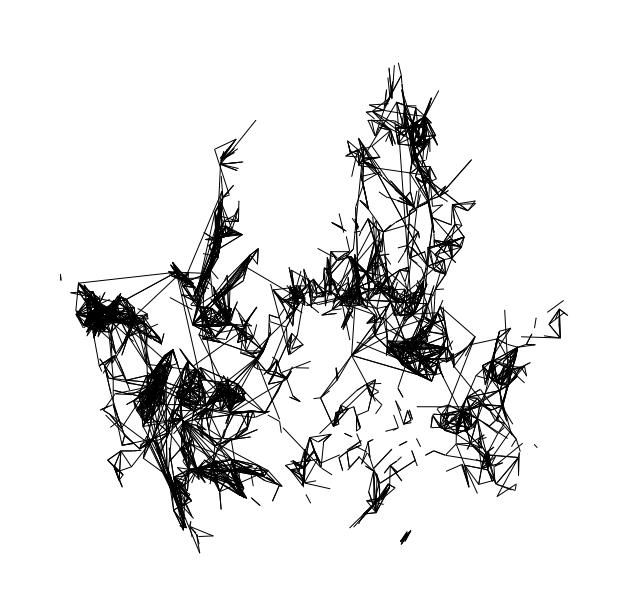

In [14]:
links1_15 = new_links(links1, 15)

G1_15 = nx.from_pandas_edgelist(links1_15, 
                             source='start',
                             target='end',
                             edge_attr='number',
                             create_using=nx.DiGraph())

plt.figure(figsize = (11,11))

nx.draw_networkx(G1_15, 
                 location, 
                 node_color='black', 
                 node_size=0, 
                 with_labels = False, 
                 arrowsize = 0.1,
                 width = 1)
plt.axis('off')
plt.show()

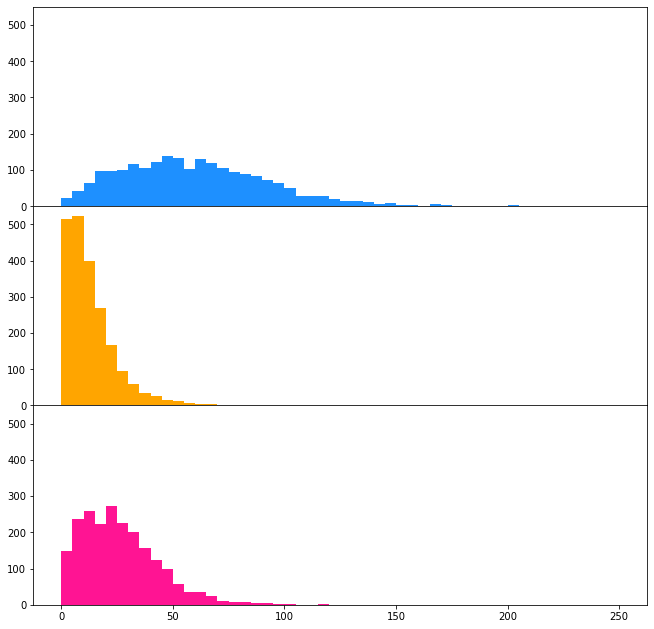

In [21]:
# in degree
bins = np.linspace(0,250,51)

# Three subplots sharing both x/y axes
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(11, 11))
ax1.hist([d for n, d in G1.in_degree()], bins=bins, color = 'dodgerblue')
ax2.hist([d for n, d in G3.in_degree()], bins=bins, color = 'orange')
ax3.hist([d for n, d in G4.in_degree()], bins=bins, color = 'deeppink')

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

# y축 퍼센트로 출력
import matplotlib.ticker as ticker
#ax1.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1053))
#ax1.set_yticks(ticks=np.arange(0, 600, 86))

plt.show()

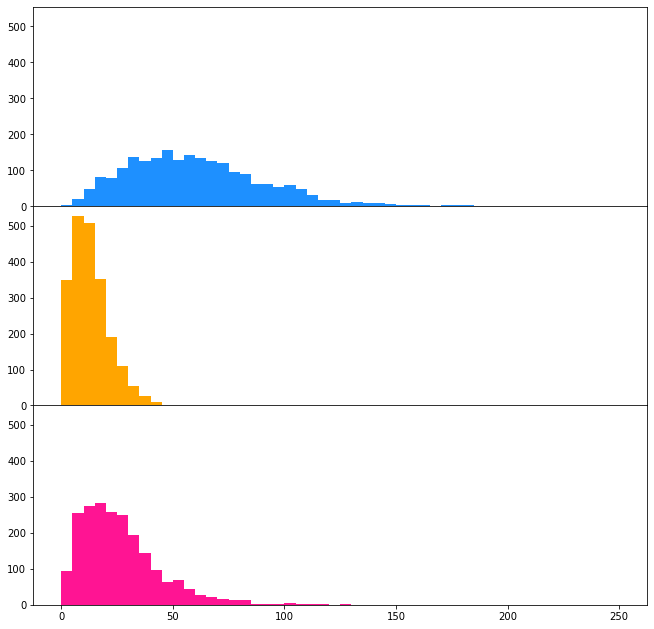

In [17]:
# out degree
bins = np.linspace(0,250,51)

# Three subplots sharing both x/y axes
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(11, 11))
ax1.hist([d for n, d in G1.out_degree()], bins=bins, color = 'dodgerblue')
ax2.hist([d for n, d in G3.out_degree()], bins=bins, color = 'orange')
ax3.hist([d for n, d in G4.out_degree()], bins=bins, color = 'deeppink')

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

# y축 퍼센트로 출력
import matplotlib.ticker as ticker
#ax1.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1053))
#ax1.set_yticks(ticks=np.arange(0, 600, 86))

plt.show()